__Introduction__

Customer Churn occurs when a customer stops using a company's products or services. Customer churn affects profitability, especially in industries where revenues are heaveily dependent on subscription s( e.g. banks, telephone and internet service providers, pay-TV compa nies, insurance firsms, etc.). It  is estimated  that acquiring a new customer can cost up to five times more than retaining an existing one. Therefore, customer churn analysis is eesential as it can help a business:

•	Identify problems in its services( e.g. poor quality product/service, poor customer support, wrong target audience, etc.)

•	Make correct strategic decisions that would  lead to higher  customer satisfaction and  consequently higher customer retention.


__Main objective of the analysis__

The goal of this work is to understand and predict customer churn for a bank. Here, we are not interested in doing inferences but only the prediction. Therefore, we will go into exploratory analysis but clean the data and use its geometry to classify the churns and non-churns using K-NN algorithm.




__Data__

We start our analysis with a data frame of lOK observations on the following 14 variables.

•	Exited: our target variable indicating whether a client exited or not the bank services (Yes/No)

•	RowNumber: row indexing count

•	Customerid: the unique identifier for each bank client

•	Surname: client's surname

•	Geography: the country of origin of the  client.  A factor with 3 levels (France, Germany and Spain)

•	Gender: a factor with 2 levels (Male/Female)

•	CreditScore: a numerical variable ranging from O to 850

•	Age: a discrete variable ranging from 18 to 92

•	Tenure : a factor with 11 levels corresponding to the number of months of retention

•	Balance: numerical variable reporting client's balance amount

•	NumOf Products: a factor with 4 levels ( 1, 2, 3 and 4)

•	HasCrCard: a factor reporting Yes if client owns a credit card and No otherwise

•	IsActiveMember: a factor with two levels

•	EstimatedSalary: a numerical variable giving bank's est imation of t heir clients annual salary (in euro)


Notice that we have three columns to remove since they do not provide any information. They are RowNumber, Customerid and Surname and we will have to predict Exited column where churn customers are labelled as 1 and non-churns as 0.


In [1]:
import os
os.chdir('C:\\Users\\barla\\OneDrive\\Desktop\\Academia\\Data Science and Economics\\Datasets')
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

# Tools for scaling data, PCA, and standard datasets
from sklearn import preprocessing, decomposition, datasets

# Tools for tracking learning curves and perform cross validation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, validation_curve, learning_curve

# The k-NN learning algorithm
from sklearn.neighbors import KNeighborsClassifier as kNN

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv('Churn_Modelling.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


We do not have any null value. Some of our features are categorical. We will need to assign dummies. 

In [3]:
data = data.drop(columns=['RowNumber','CustomerId','Surname'])
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
#Create dummies

gender_dummies = data.replace(to_replace={'Gender': {'Female': 0,'Male':1}})
a = pd.get_dummies(data['Geography'], prefix = "Geo_dummy")
frames = [gender_dummies,a]
data = pd.concat(frames, axis=1)
data = data.drop(columns=['Geography'])
data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geo_dummy_France,Geo_dummy_Germany,Geo_dummy_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0,0,1


In [5]:
#Drop the label column

x=data.drop(['Exited'],axis=1)
y=data['Exited']

In [6]:
np.unique(y, return_counts=True)

(array([0, 1], dtype=int64), array([7963, 2037], dtype=int64))

We have around 8000 customers who did not churn and around 2000 customers who churned. This is an inbalanced dataset which is a problem for our analysis. We know that in K-NN the classifications are based on majority voting, however here using majority rule is not a good idea since the algorithm will fail to correctly classify those who did churn due to the inbalanceness that exist in our dataset. That is why we will instead use the probabilities assigned to each data point for its classification.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size= 0.3, random_state = 42, stratify = y)


We have a relatively big data, so it makes sense to divide it as %70 training and %30 test set.

We are now ready to train a classifier for this dataset. We create a 1-NN classifier object by invoking the function kNN(n_neighbors=1), where kNN() is the alias we created when we imported the module for KNeighborsClassifier(). The object is assigned to the variable knn.

What nearest neigbor is really doing is the following: we have 10 measurements for each observation, so a matrix with 10 dimensions. We cannot see it neither view it but we know that it exists in the space. It is a mathematical construction. So we have this clouds of points in this 10 dimensional space and each point has a color. Color red for exited and green for non-exited, let's say. We split these points into subsets, training and test. Assume that we take out the test points and we are left %70 of original points in a random cloud. We give those points to the algorithm. What the algorithm does is to produce a classifier based on this %70 of original points. We then put back in those taken out points without the label and let the algorithm finds their place in this 10 dimensional space. What is the color of this point? Red or Green?

What K means does is to memorize all the training set. It takes %70 of the points and stores them in the memory. Everytime we give to it a new point, it looks at the K closest point that it had in the training set. It measures the distance in this 30 dimensional space with Euclidean formula which works well for any finite dimensions.

In [8]:
knn = kNN(n_neighbors=1)
knn.fit(X_train, y_train)
knn.score(X_train, y_train), knn.score(X_test, y_test)


(1.0, 0.682)

Training accuracy turns out be 1 while testing is .68. We already knew that it would be %100 accurate on the train dataset since the algoritm memorizes all the train dataset. On the test data, on the other hand, the accurary is about %68 percent where every point is compared with the closes training point which is then given the label of the closest training point.

let's use the same training and test set however this time with 3 nearest neighbor. Now, the classification will be done based on the majority vote of the first three closest training points neigbors.

In [9]:
knn= kNN(n_neighbors=3)
knn.fit(X_train, y_train)
knn.score(X_train, y_train), knn.score(X_test, y_test)

(0.8382857142857143, 0.7363333333333333)

How come the training accuracy is not 1? ıt still memorizes the training set but it is applying the nearest neighbor rule. So suppose that we have a training point and we(algorithm) know the label of this training point because we memorized it. However, we are a three nearest neighbor classifer. We should use the three training points closest to this training point to make a classification. That's the definition of training error. The closest point to the training point will be itself but then we have two others points and they might have labels equal or disagreeing with our training point. So if we have a training point in a sea of training points of different color, it will be classified wrongly. Even if the algorithm knows its label, it still applies the three nearest neighbor rule.

However, we are doing better on the new data, namely, the test data! That's actually what we are interested in! We want to see how it does with the data it has never seen before.

Predictably, the training accuracy went down (by about 17%), while the test accuracy is now pretty close to the training accuracy.

Next, we use the function learning_curve() to inspect the evolution of training and test performance of 7-NN for increasing sizes of the training set.

For each value of the training set size, a 5-fold stratified cross-validation is performed to estimate the risk.

In [10]:
sizes= np.arange(0.1, 0.9, 0.1)
train_size, train_score, val_score = learning_curve(kNN(n_neighbors = 7), x, y, train_sizes= sizes, cv=5)

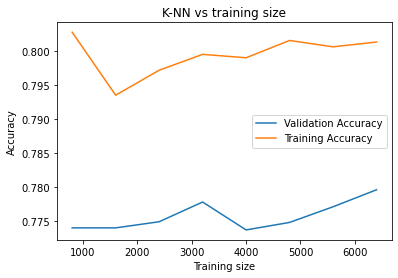

In [11]:
plt.title("K-NN vs training size")
plt.plot(train_size,np.mean(val_score,1), label='Validation Accuracy')
plt.plot(train_size,np.mean(train_score,1), label="Training Accuracy")
plt.legend()
plt.xlabel("Training size")
plt.ylabel("Accuracy")
plt.show()

For this particular dataset, we conclude that the training size does not change the result a lot. This is probably the inbalancesness that exist in our dataset. The relative sizes of churns and non-churns do not really change a lot with respect to the training size provided to the algorithm.
We can still do more in developing our model. We could measure the behaviour of the training and test set as a function of the number of the nearest neighbor, K. So, we basically want to know what value of parameter to use, what value of K maximizes
our accuracy on the test data?

In [12]:
neighbors = range(1,30,1)

train_score, val_score = validation_curve(kNN(), x, y, 'n_neighbors', neighbors, cv=5)
train_score, val_score

C:\Users\barla\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass param_name=n_neighbors, param_range=range(1, 30) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


(array([[1.      , 1.      , 1.      , 1.      , 1.      ],
        [0.8375  , 0.84425 , 0.839   , 0.839875, 0.840125],
        [0.841875, 0.84375 , 0.843   , 0.839625, 0.838875],
        [0.817   , 0.812875, 0.815875, 0.814875, 0.81575 ],
        [0.816   , 0.814   , 0.8155  , 0.818375, 0.816125],
        [0.80625 , 0.80625 , 0.807125, 0.807125, 0.806625],
        [0.805875, 0.807875, 0.807125, 0.807125, 0.8045  ],
        [0.8005  , 0.80175 , 0.8025  , 0.802125, 0.8025  ],
        [0.801875, 0.801375, 0.800625, 0.80225 , 0.802375],
        [0.79875 , 0.8     , 0.798625, 0.801   , 0.80125 ],
        [0.798125, 0.800125, 0.79725 , 0.800375, 0.800875],
        [0.797375, 0.799375, 0.795625, 0.799375, 0.798875],
        [0.79725 , 0.7985  , 0.79675 , 0.79975 , 0.8     ],
        [0.796875, 0.79825 , 0.795875, 0.79775 , 0.797625],
        [0.79775 , 0.798875, 0.79575 , 0.797875, 0.79875 ],
        [0.796875, 0.797   , 0.795   , 0.797375, 0.79775 ],
        [0.796875, 0.798875, 0.7965  , 0

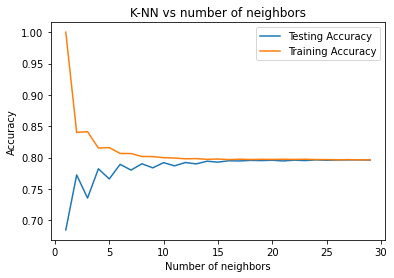

In [13]:
plt.title('K-NN vs number of neighbors')
plt.plot(neighbors, np.mean(val_score,1), label='Testing Accuracy')
plt.plot(neighbors, np.mean(train_score,1), label="Training Accuracy")
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

The left side of the plot, where the testing accuracy and the training accuracy is very apart from each other is the region where there is overfitting. The training accuracy is really high because it is fitted so well on it but it is low in the testing accuracy.
Afte a certain number of neighbors which is around 18, our accuracy becomes constant. Probably because, the particular distribution of the data points on the 10 dimensional space leads to this result. After around K=18, the number of neighbors provided do not change the accuracy.


In [14]:
k_grid = {"n_neighbors":range(1,100,20)}
learner = GridSearchCV(estimator=kNN(), param_grid = k_grid, cv=5, return_train_score=True)
learner.fit(x,y)
learner.best_params_, learner.best_score_

({'n_neighbors': 41}, 0.7963)

So now, let's assume that we do not care about the testing. What we care about is only finding the right parameter. So, we take all the data we have and just want to determine the best value of the parameter for this data. So what do we do? We first of all decide which values to explore and then create a grid as above which is a dictionary. we then train the algorithm for each one of the values in the grid and we repeat the operation for each of those values. So we pick a value, we run 5 cross-validations on it: meaning that we train the algorihtm 5 times with the same value of K each time taking out %20 of the data and train on the remaning %80 and then compute the mean. And then we take another value of K in the grid and repeat this operation for each value in the grid and we are looking for the best cross-validated performance: the best value of K that is associated with the highest average.

With K=41, we get the highest testing accuracy. However, this is a very high value for K and it is actually against the idea of similarity that is behind the algorithm. Also, we know that the accuracy becomes stable around 18 so we do not need to make it more complex with 41 parameters.

In [15]:
model = learner.best_estimator_
scores = cross_val_score(model,x,y,cv=5)
scores.mean()

0.7963


We saw that cross-validation allows us to use the data for choosing a good value of the parameter. However, we are still left with the problem of estimating the risk of the classifier generated by the algorithm. Nested cross-validation provides a way of estimating the risk of a classifier generated by an algorithm whose parameters are tuned using cross-validation on the training set.

In the following example, we:

Run 5-fold cross-validation on the entire dataset.

On the training part of each fold, run internal 5-fold cross-validation to find the best value of the parameter.

Re-train the model on the training part of the outer fold using the optimized parameter.

Test the model on the testing part of the outer fold.

In [16]:
k_grid = {'n_neighbors': range(1,100,20)}
learner = GridSearchCV(estimator=kNN(), param_grid=k_grid, cv=5) # internal C-V
scores = cross_val_score(learner, x, y, cv=5) # external C-V
scores, scores.mean()

(array([0.796 , 0.796 , 0.7965, 0.7965, 0.7965]), 0.7963)

Note that the nested cross-validated estimate turned out be the same as CV.


We can now do better by scaling down our dataset.


In [17]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size= 0.3, random_state = 42, stratify = y)
standard_scaler = preprocessing.StandardScaler()
X_train_standard = standard_scaler.fit_transform(X_train)#computes the mean and Sd for each feature
X_test_standard = standard_scaler.transform(X_test) #transforms the data according to the stats computed above line.

In [18]:
neighbors = range(1,30,3)
test_scores = []
test_scores_standard =[]

for k in neighbors:
    knn = kNN(n_neighbors=k)
    knn.fit(X_train, y_train)
    test_scores.append(knn.score(X_test,y_test))
    knn.fit(X_train_standard,y_train)
    test_scores_standard.append(knn.score(X_test_standard,y_test))

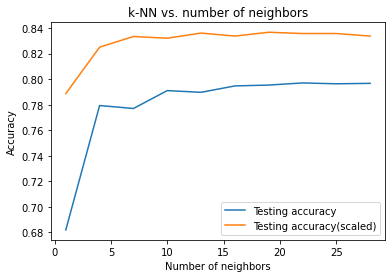

In [19]:
plt.title('k-NN vs. number of neighbors')
plt.plot(neighbors, test_scores, label='Testing accuracy')
plt.plot(neighbors, test_scores_standard,label='Testing accuracy(scaled)')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

As we can see, the testing accuracy of the scaled dataset is always higher than the unscaled one. Scaling the features helped us a lot in terms of prediction. On the scaled dataset, we have the highest accuracy at around 19 neighbors.

In [20]:
knn_final= kNN(n_neighbors=19)
knn_final.fit(X_train_standard,y_train)
knn_final.score(X_test_standard,y_test)


0.8366666666666667

Our testing accuracy is %83 which is not bad. However, we expect this model to classify badly the ones who did not churn.

In [21]:
predict = knn_final.predict(X_test_standard)


In [22]:
a,b,c,d=confusion_matrix(predict,y_test)[0,0],confusion_matrix(predict,y_test)[0,1],confusion_matrix(predict,y_test)[1,0],confusion_matrix(predict,y_test)[1,1]
sensitivity = (a/(a+c))*100
specificity =(d/(d+b))*100

sensitivity, specificity

(97.57220594390958, 29.296235679214405)

As we can see, we are doing pretty good in predictings those who did not churn but doing really bad in predicting those who churned. This is a general problem in inbalanced datasets. We are able to classify correctly only %30 of the churned customers.

In [23]:
knn_probs = knn_final.predict_proba(X_test_standard) # predict the probabilities


We will now do the classfication based on the probabilities we get above and as thresholds, we use the grid list defined below that are values ranging from 0.1 to 0.9. This operation will return a 9D array with 3000 rows each D representing a threshold with classifications.

In [24]:
grid= [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
res = np.zeros((knn_probs.shape[0],len(grid)))
row=0
while row < len(knn_probs)-1:
    for threshold in grid:
        row=0
        for probs in knn_probs[:,1]:
            if(probs>threshold).all():
                res[row,grid.index(threshold)]=1
                row+=1
            else:
                res[row,grid.index(threshold)]=0
                row+=1 

In [25]:
specificity=[0 for i in range(0,res.shape[1])]
sensitivity=[0 for i in range(0,res.shape[1])]

for i in range(0,res.shape[1]):
    a,b,c,d=confusion_matrix(res[:,i],y_test)[0,0],confusion_matrix(res[:,i],y_test)[0,1],confusion_matrix(res[:,i],y_test)[1,0],confusion_matrix(res[:,i],y_test)[1,1]
    sensitivity[i] = (a/(a+c))*100
    specificity[i] = (d/(d+b))*100

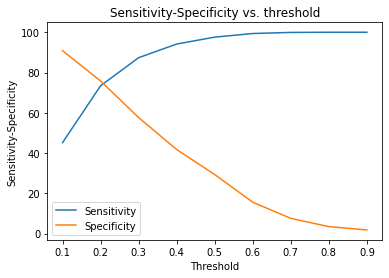

In [26]:

plt.title('Sensitivity-Specificity vs. threshold')
plt.plot(grid,sensitivity,label='Sensitivity')
plt.plot(grid,specificity,label='Specificity')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Sensitivity-Specificity')
plt.show()

As we can see, when the probabilities threshold used to classify the points increases, so when we approach the majority voting system which is the default in Knn, we have a really high sensitivity but low specificity. We cannot correctly classify the ones who did not churn. Around threshold 0.2, we get a nice trade off where we correctly classify around 73% of both classes which is the maximum we can get for this dataset with K-NN.

In [27]:
res= []
for i in knn_probs[:,1]:
    if  (i>0.2).all():
        res.append(1)
    else:
        res.append(0)

In [28]:
a,b,c,d=confusion_matrix(res,y_test)[0,0],confusion_matrix(res,y_test)[0,1],confusion_matrix(res,y_test)[1,0],confusion_matrix(res,y_test)[1,1]
sensitivity = (a/(a+c))*100
specificity =(d/(d+b))*100

sensitivity, specificity

(73.41984093763081, 75.77741407528642)

With the threshold 0.2, we are able to classify %73 of churns and %75 of non-churns correctly.